In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/AI_data"

### 1. 데이터 불러오기

In [ ]:
# 일부 행이 세미콜론(;)으로 끝나므로, 이를 제거하는 전처리를 포함
df = pd.read_csv(file_path + '/WISDM_ar_v1.1_raw.txt', header=None, names=['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis'], on_bad_lines='skip') # on_bad_lines='skip' -> 잘못된 형식의 줄을 skip
df['z-axis'] = df['z-axis'].str.replace(';', '').astype('float')
df.dropna(inplace=True) # 결측치 제거
df.to_csv(file_path + '/WISDM_HAR.csv', index=False, encoding='utf-8-sig')

### 2. 데이터 기본 정보 출력

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086465 entries, 0 to 1086465
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086465 non-null  int64  
 1   activity   1086465 non-null  object 
 2   timestamp  1086465 non-null  int64  
 3   x-axis     1086465 non-null  float64
 4   y-axis     1086465 non-null  float64
 5   z-axis     1086465 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


In [ ]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
# 기술 통계 요약
df.describe()

,user,timestamp,x-axis,y-axis,z-axis
count,1.086465e+06,1.086465e+06,1.086465e+06,1.086465e+06,1.086465e+06
mean,1.883756e+01,3.250279e+13,6.641130e-01,7.246045e+00,3.976974e-01
std,1.026681e+01,4.893650e+13,6.876277e+00,6.739789e+00,4.761111e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,1.999712e+12,-2.910000e+00,3.170000e+00,-2.220117e+00
50%,1.900000e+01,9.396203e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,3.509473e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


In [ ]:
df.isnull().sum()

,0
user,0
activity,0
timestamp,0
x-axis,0
y-axis,0
z-axis,0


### 3. 데이터 시각화

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Walking'),
  Text(1, 0, 'Jogging'),
  Text(2, 0, 'Upstairs'),
  Text(3, 0, 'Downstairs'),
  Text(4, 0, 'Sitting'),
  Text(5, 0, 'Standing')])

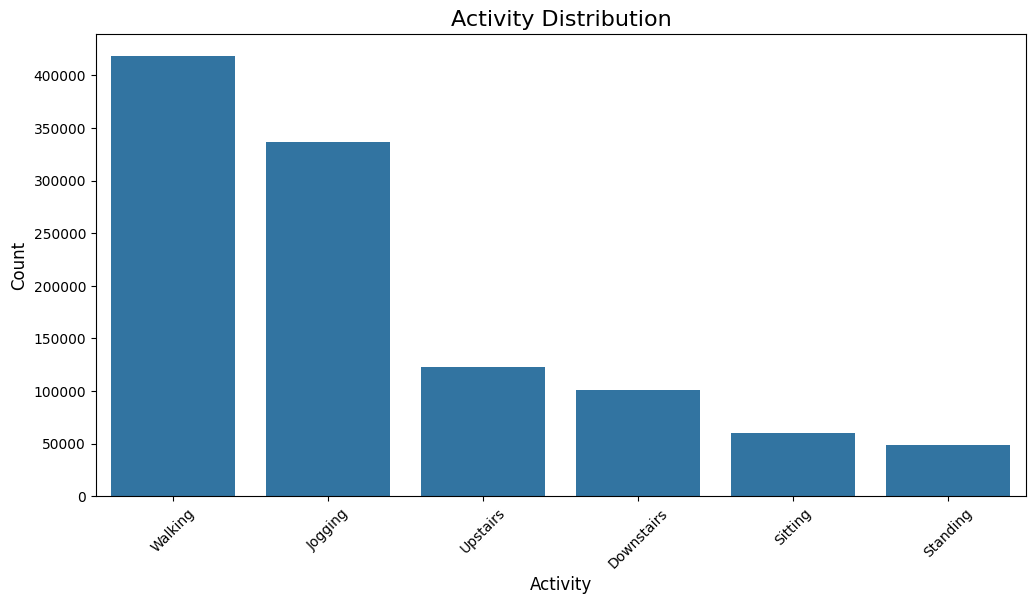

In [ ]:
# 활동별 데이터 분포 시각화
plt.figure(figsize=(12, 6))
sns.countplot(x='activity', data=df, order=df['activity'].value_counts().index)
plt.title('Activity Distribution', fontsize=16)
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

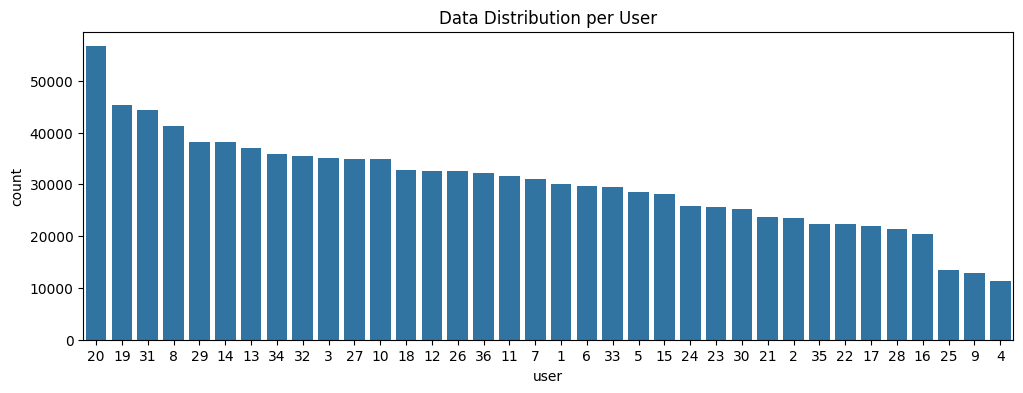

In [ ]:
# 피험자 별 데이터 분포 시각화
plt.figure(figsize=(12, 4))
sns.countplot(x='user', data=df, order=df.user.value_counts().index)
plt.title("Data Distribution per User")
plt.show()

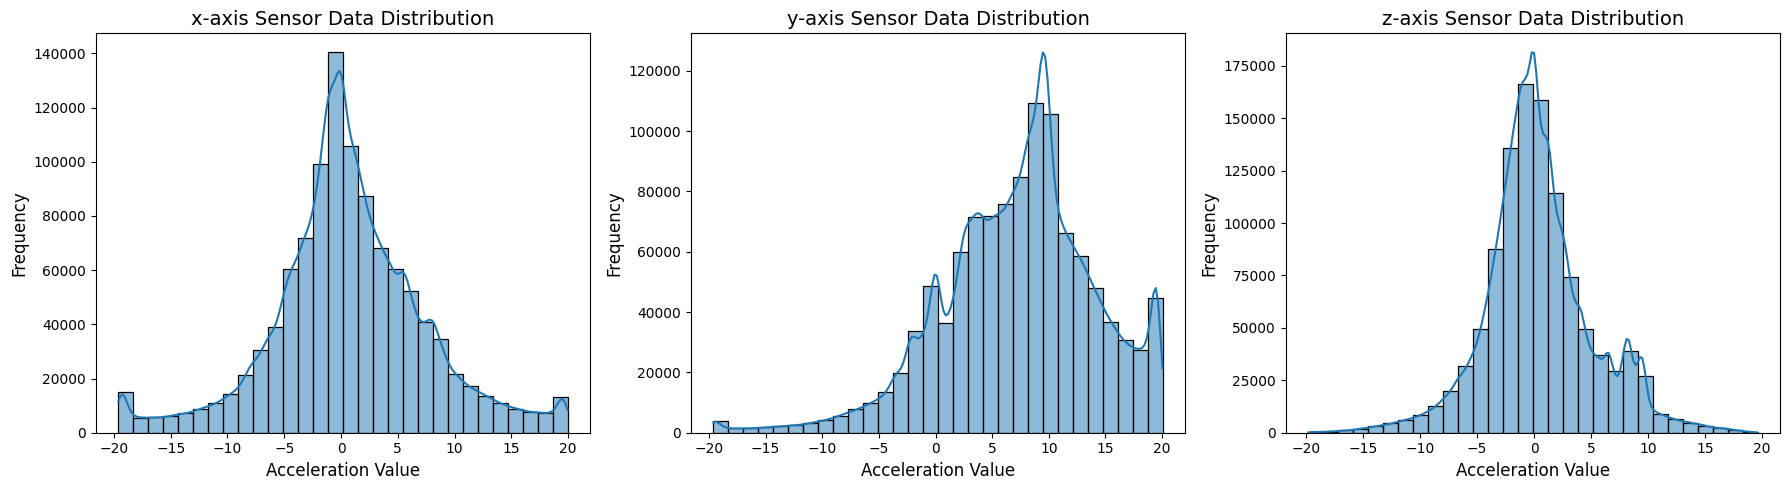

In [ ]:
# 센서 축(x, y, z)별 데이터 분포 시각화
plt.figure(figsize=(18, 5))
for i, col in enumerate(['x-axis', 'y-axis', 'z-axis']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} Sensor Data Distribution', fontsize=14)
    plt.xlabel('Acceleration Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()

#### 시간 영역(Time Domain) 분석
- 시간의 흐름에 따라 센서의 x, y, z 값이 어떻게 직접적으로 변하는지 봄
- 신호의 전체적인 크기나 진폭, 역동성, 순간적 충격 등을 알 수 있음
- y축: 센서 값, 움직임이 클수록 위아래로 흔들리는 폭(진폭)이 커짐 -> 움직임의 강
- 주기적인 패턴을 한 눈에 파악하기 어려움 -> 주파수 영역 분석으로 파악해야 함

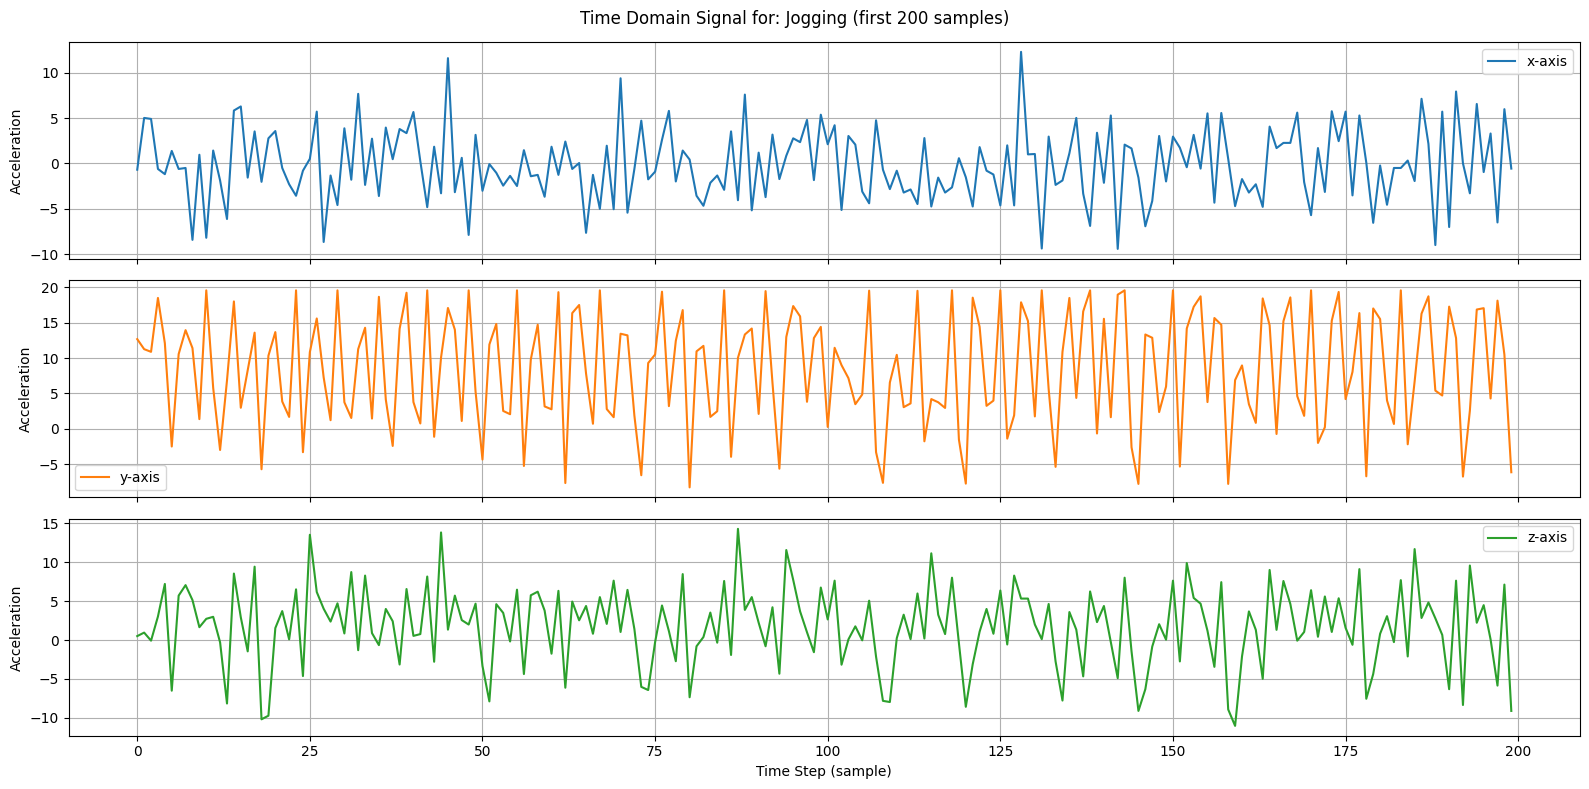

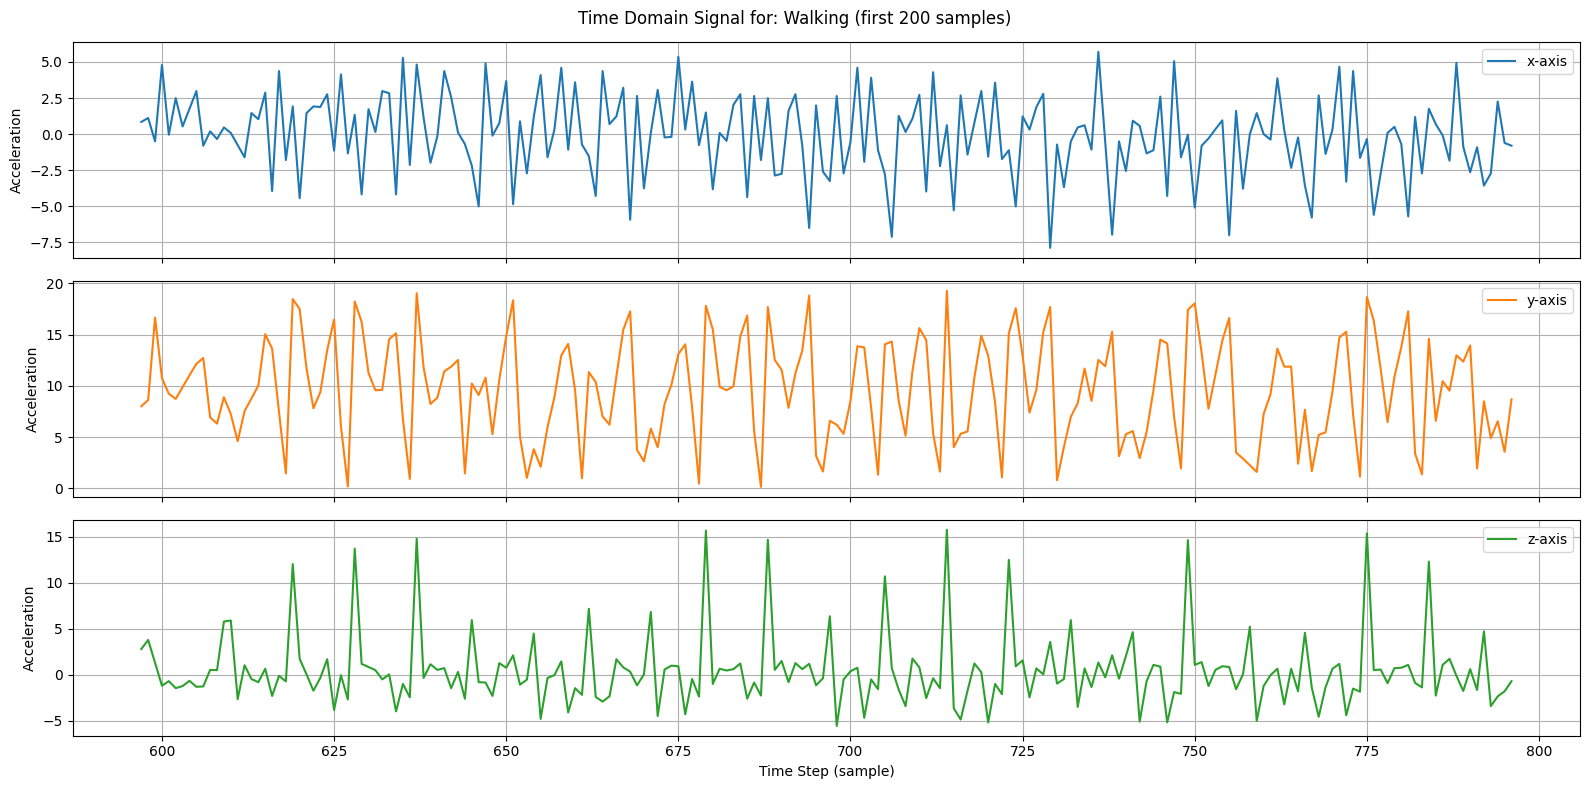

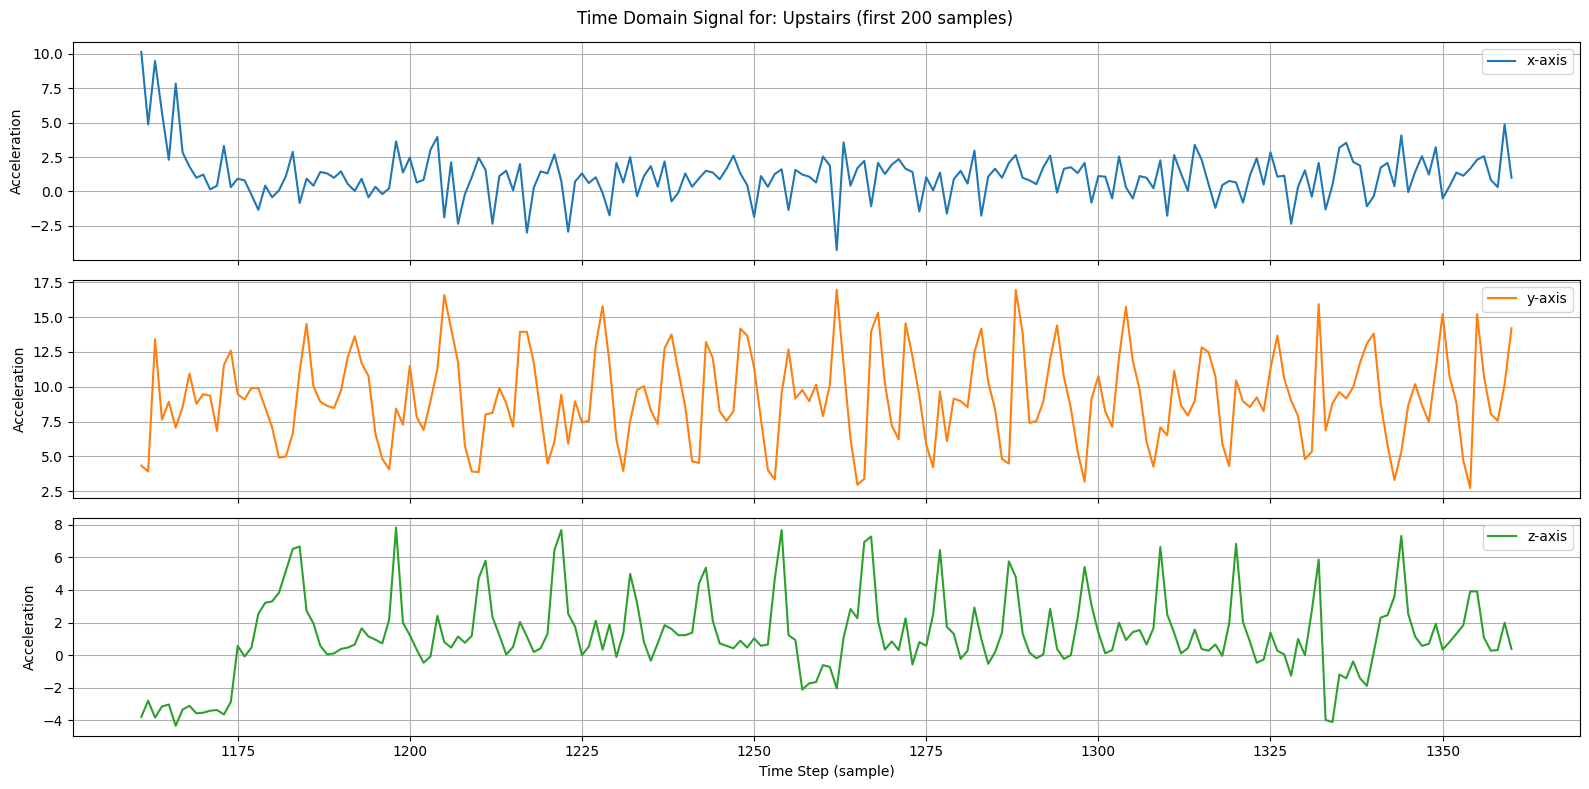

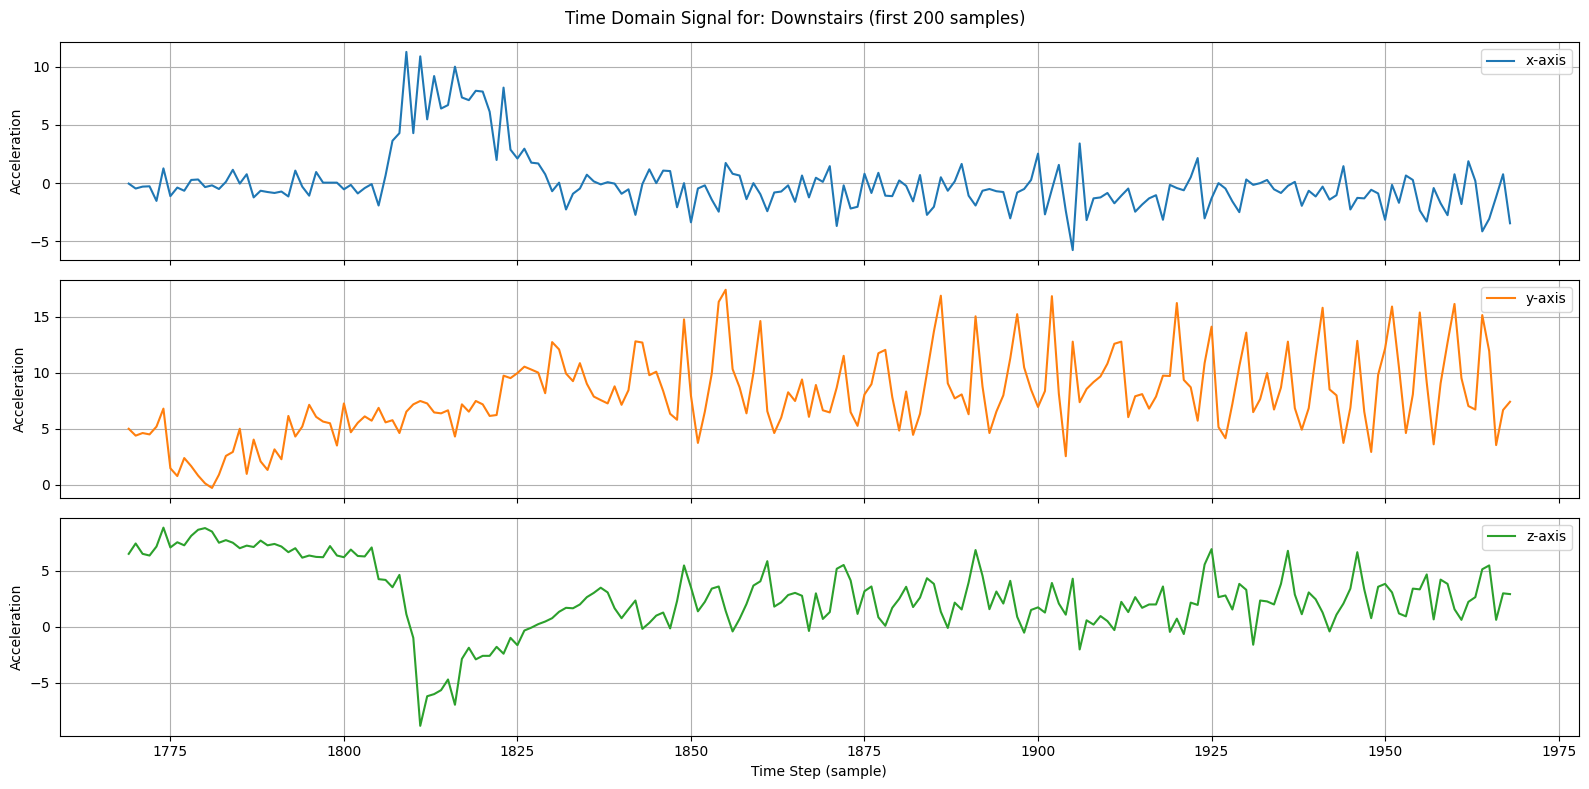

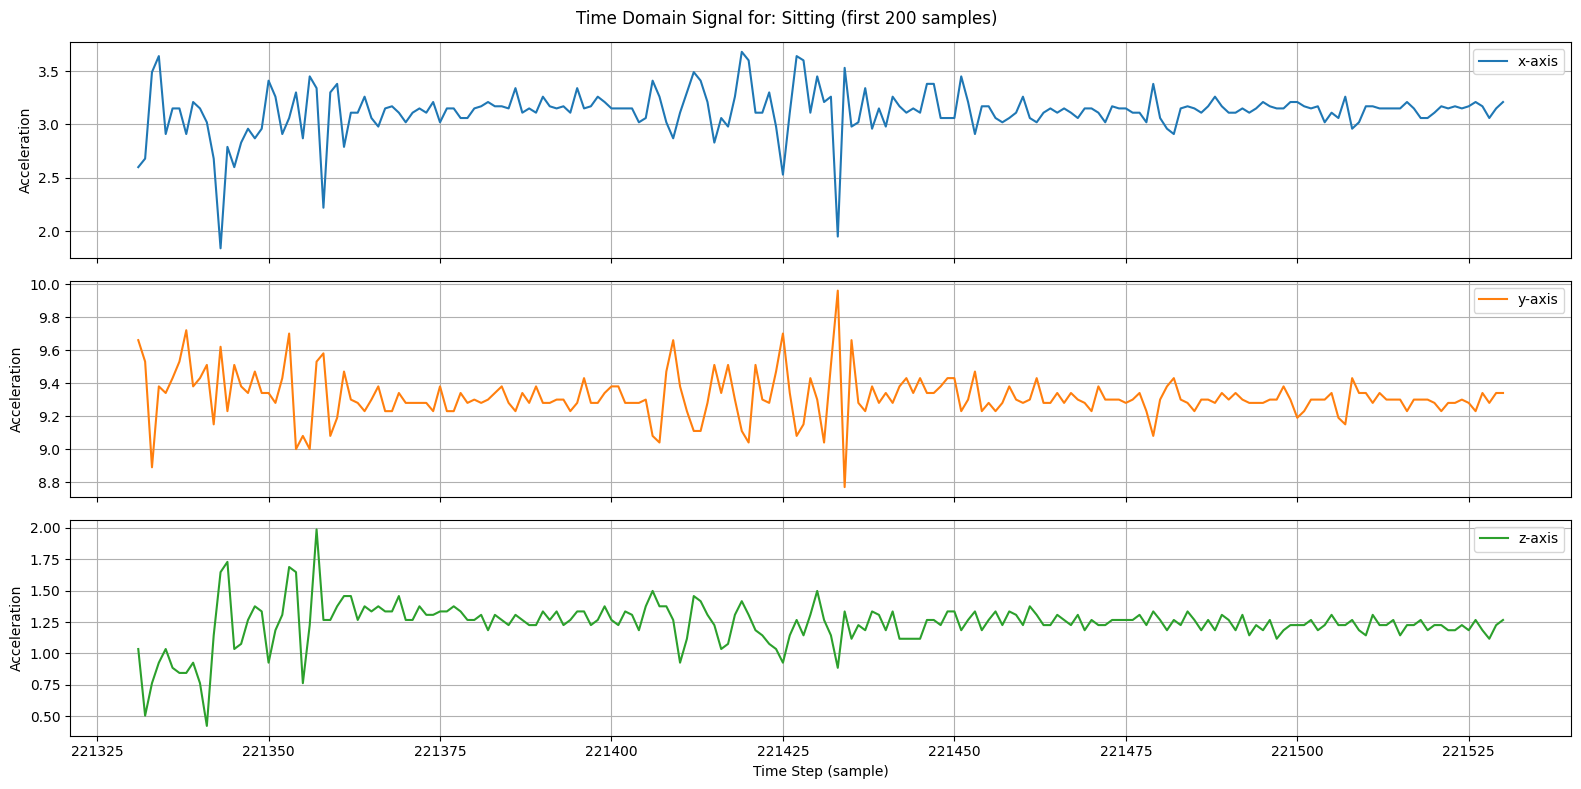

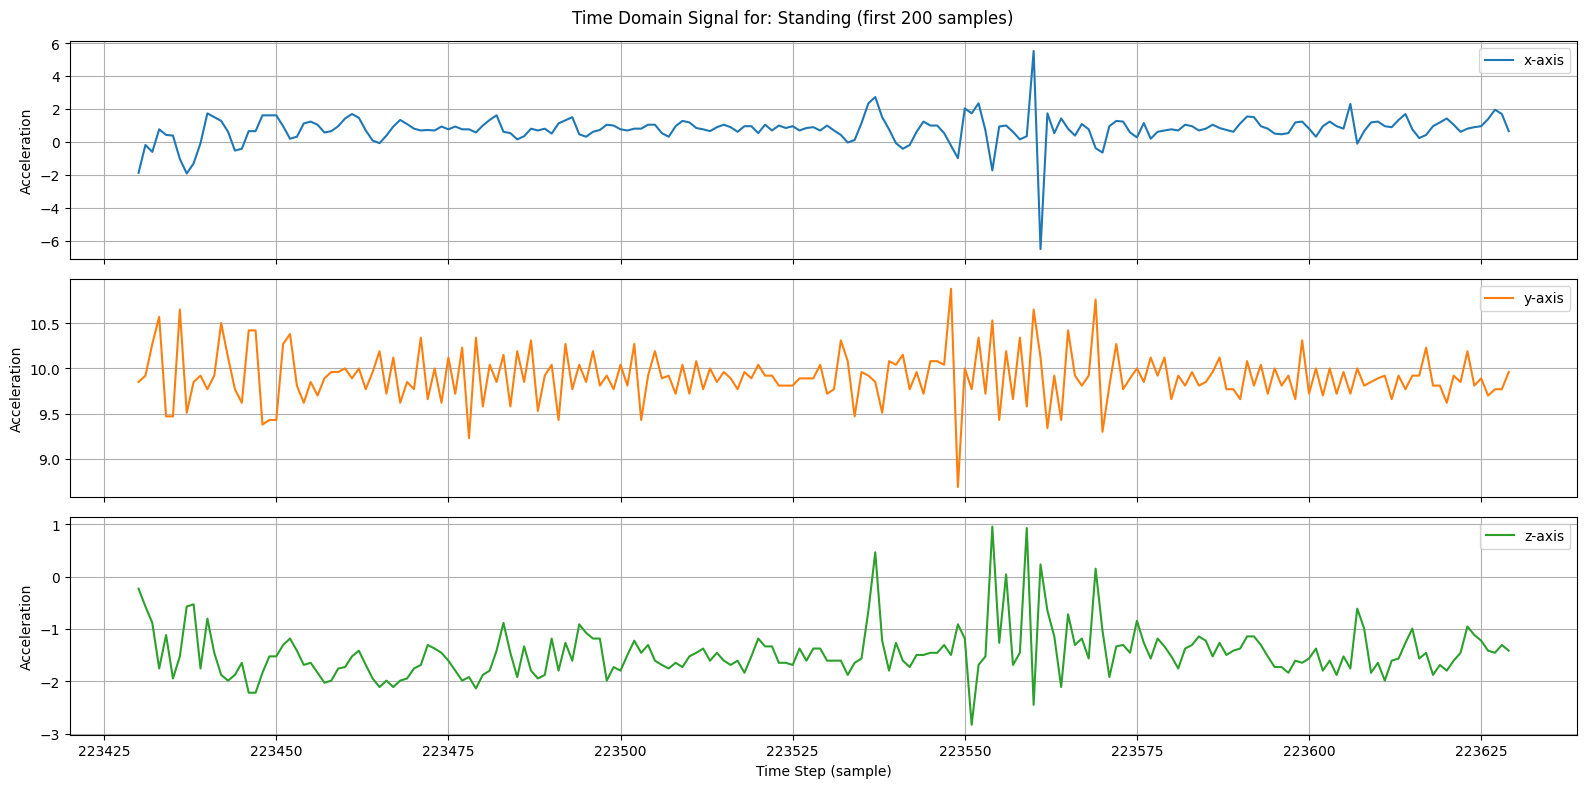

In [ ]:
activities = df['activity'].unique()

for activity in activities:
    # 초기 200개의 데이터 포인트만 선택
    data_subset = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]

    axis = data_subset.plot(subplots=True, figsize=(16, 8),
    title=f'Time Domain Signal for: {activity} (first 200 samples)')

    # 각 서브플롯의 범례(legend) 위치 조정
    for ax in axis:
        ax.legend(loc='best')
        ax.set_xlabel("Time Step (sample)")
        ax.set_ylabel("Acceleration")
        ax.grid(True)

    plt.tight_layout()

#### 주파수 영역(Frequency Domain) 분석
- 주기적인 특성을 가진 활동과 그렇지 않은 활동을 구분할 수 있게 해줌 (e.g., walking: 반복적 패턴, sitting: 특별한 주기성 없음)
- FFT (고속 푸리에 변환, 시간 -> 주파수 영역 변환)을 통해 분석
- 각 activity 별로 어떤 주파수의 신호가 얼마나 센지(amplitude) 보여줌
- e.g., '이 신호에는 1초에 2번 반복되는 패턴(2Hz)이  가장 강하게 포함되어 있구나'를 알 수 있다!
- e.g., walking의 경우, 사람의 평균 보폭 주파수는 1-3Hz (1초에 1-3걸음)
-> 그래프에서도 2Hz 정도에서 피크를 보임
- 반면 sitting 같은 정적인 동작은 세 축 모두 큰 변화 없음
- x축은 좌우 움직임, y축은 앞뒤 움직임(전진), z축은 상하 움직임을 측정
- DC 성분: 센서의 변하지 않는 평균값(0Hz), 가속도계는 항상 중력의 영향을 받음. 따라서 0Hz에 데이터가 많이 분포
- 양의 주파수 영역만 사용한 이유 -> FFT를 실수 신호에 적용하면 0Hz를 기준으로 양수 주파수와 음수 주파수가 대칭, 따라서 계산량을 줄이고 그래프의 직관성을 위해 양수 주파수 영역만 본다.

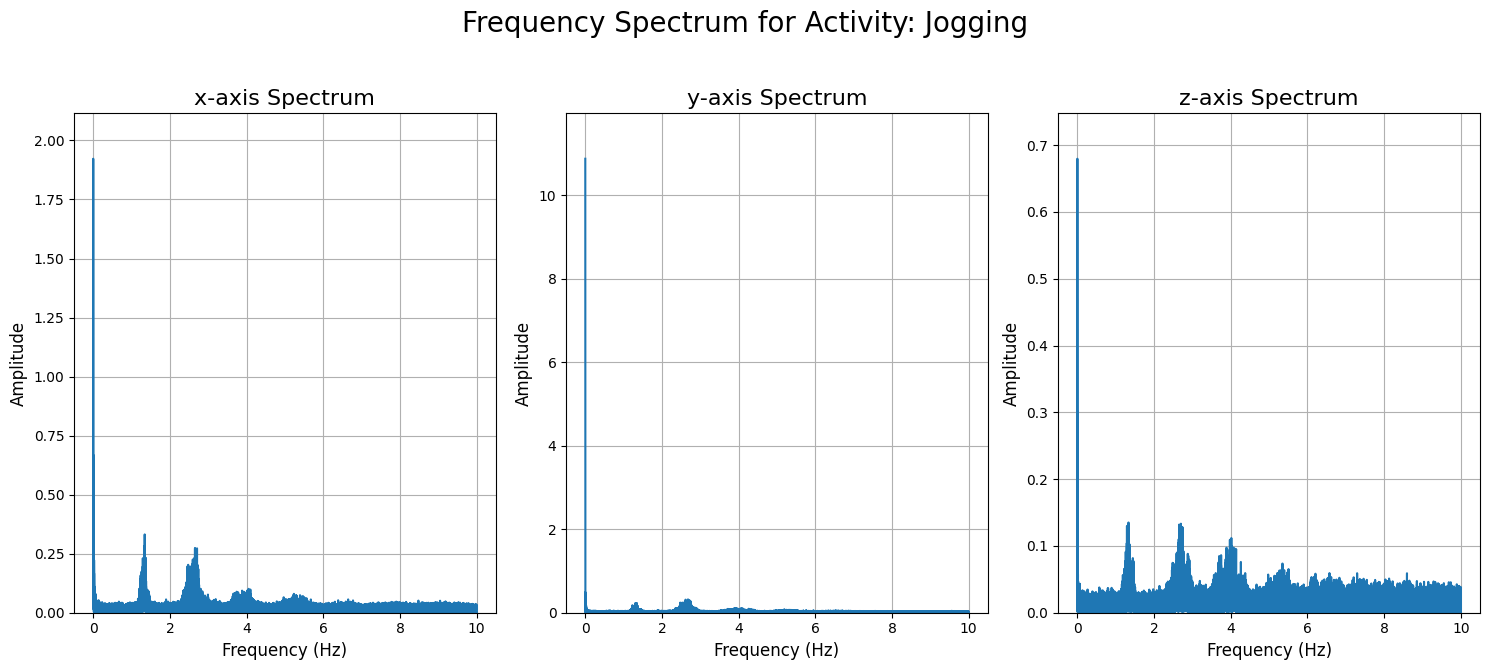

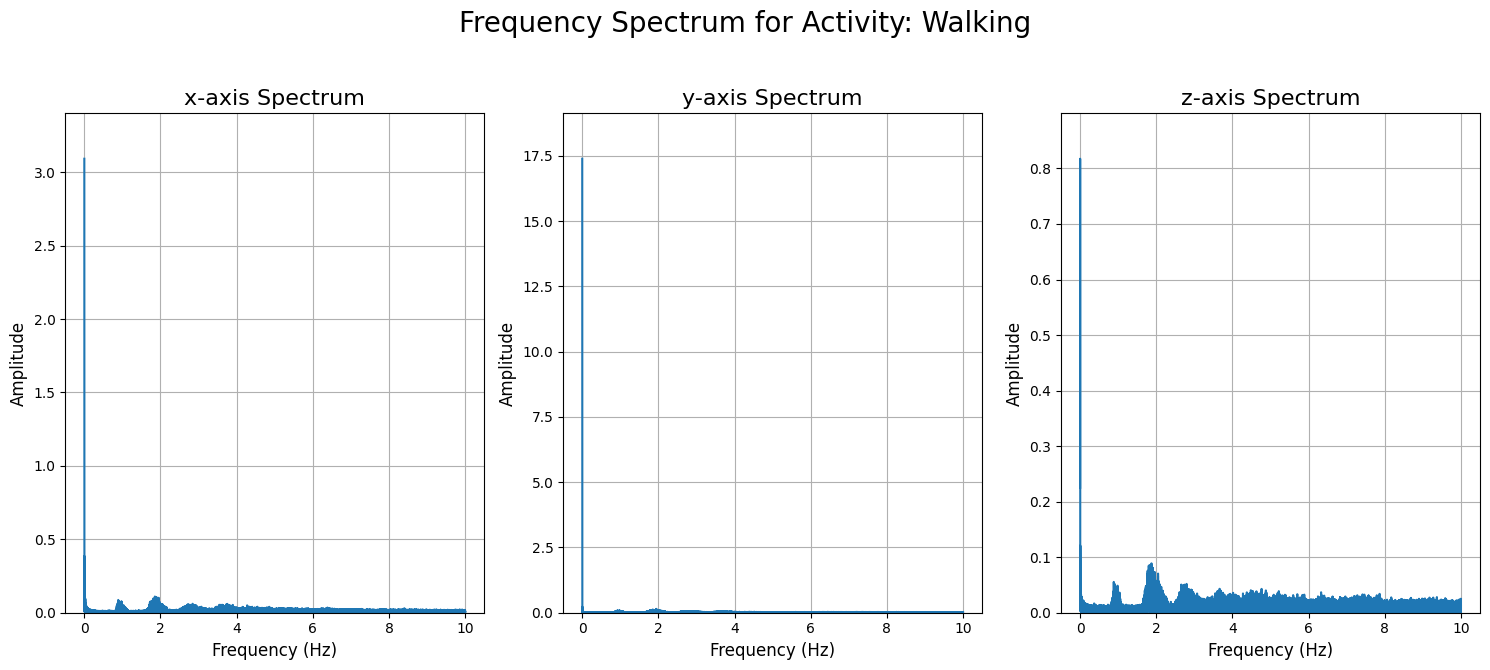

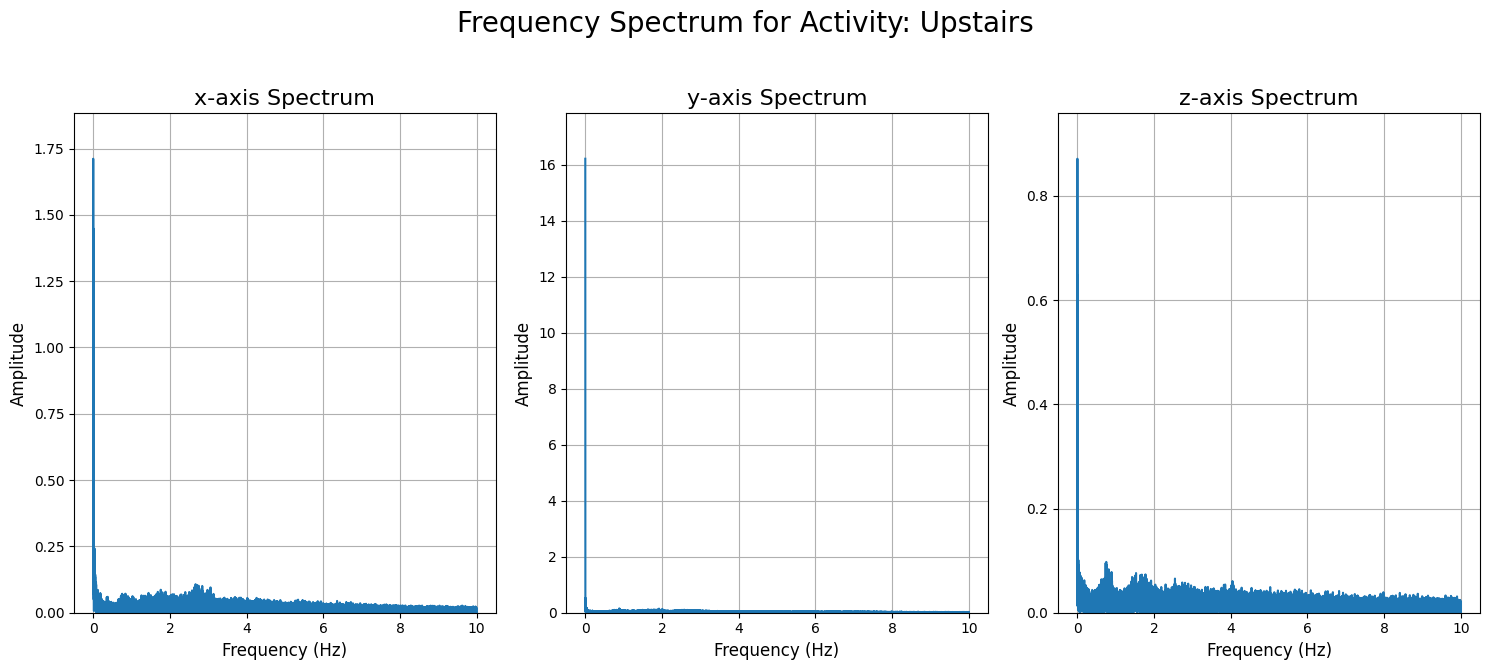

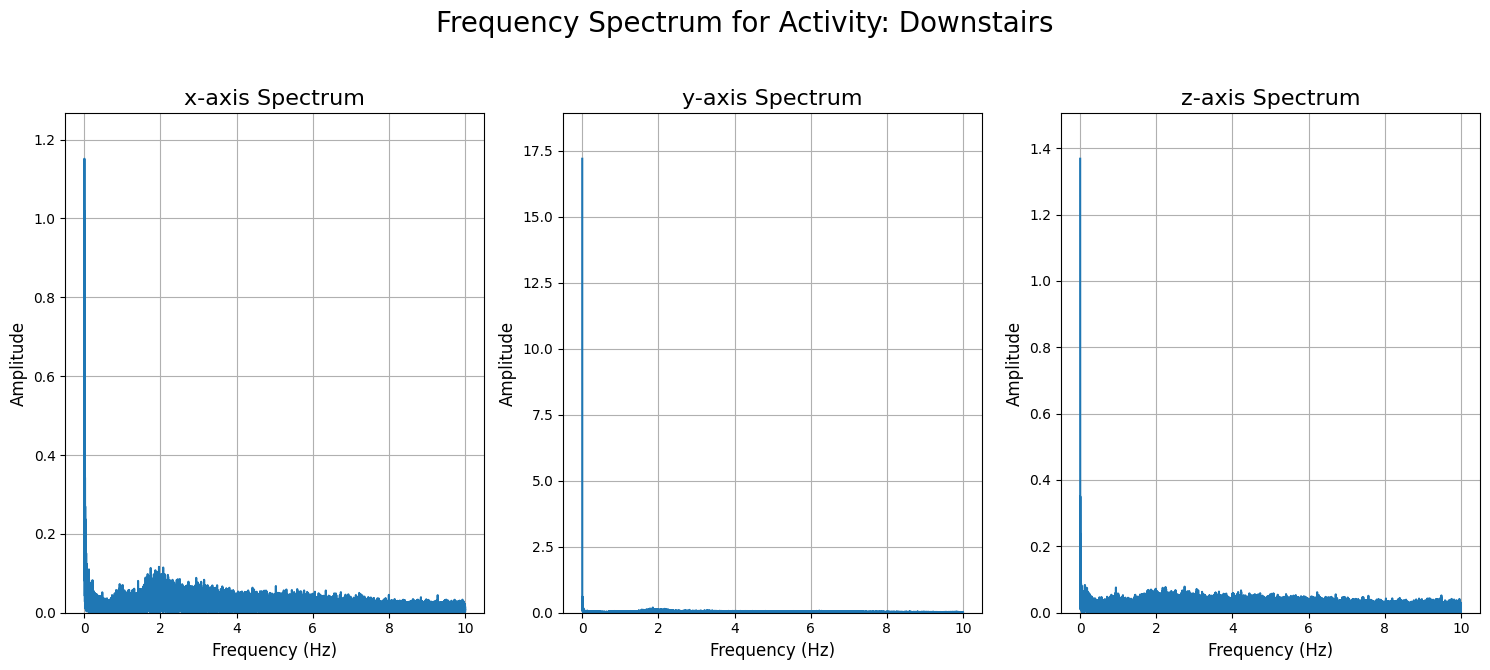

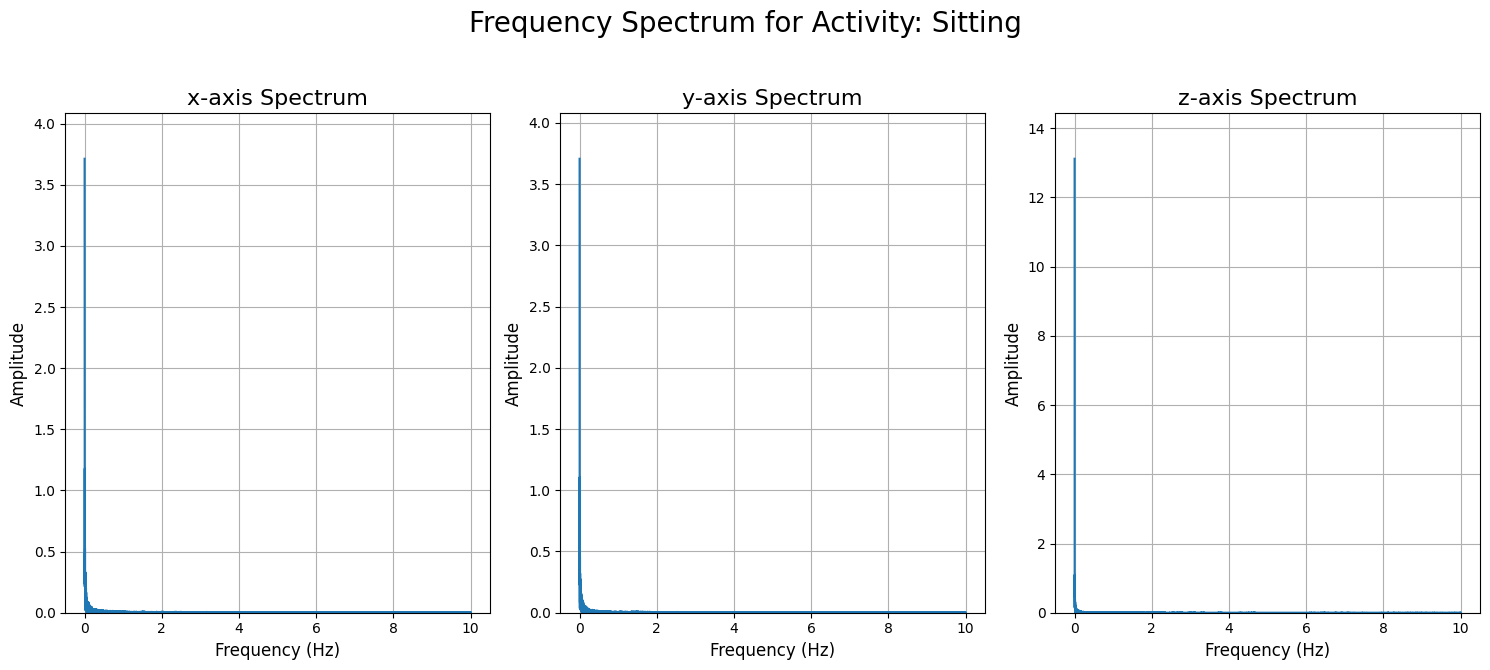

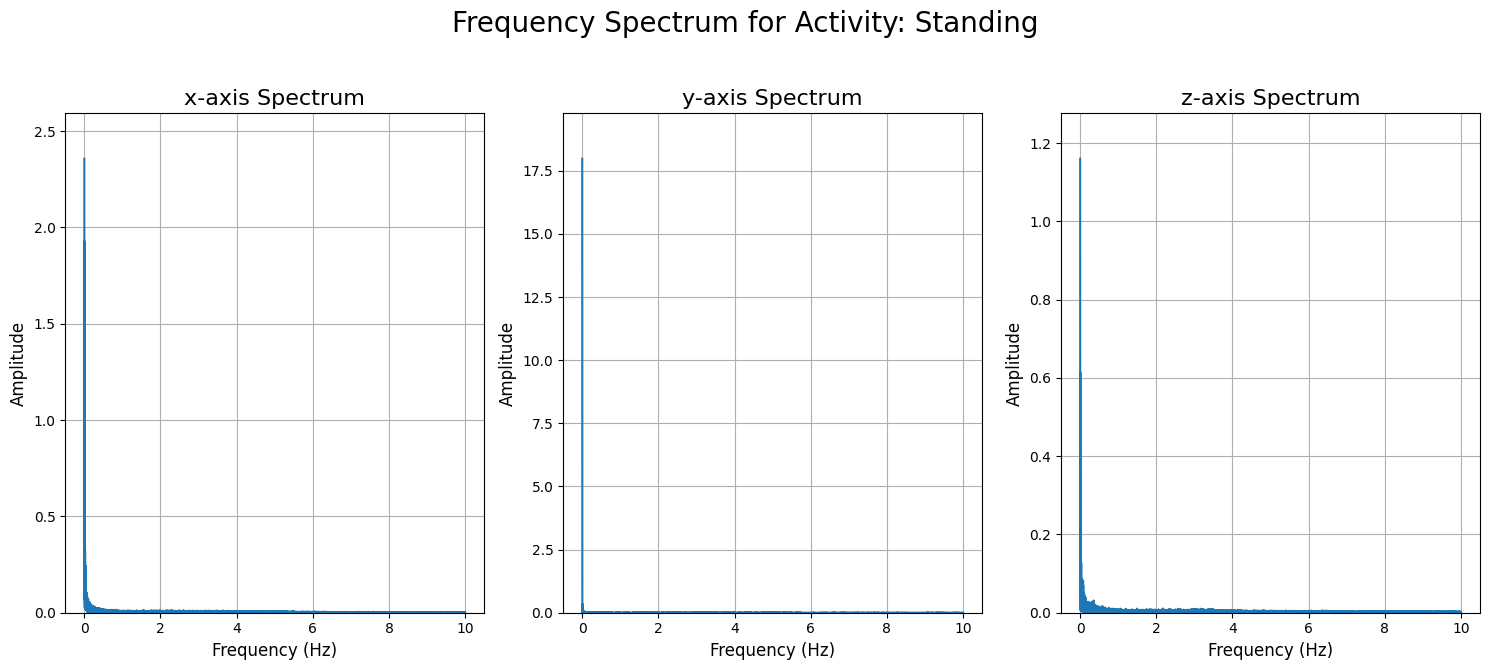

In [ ]:
# 주파수 분석 (FFT)

SAMPLING_FREQUENCY = 20  # 20 samples per second

# 분석할 활동 목록
activities = df['activity'].unique()

for activity in activities:
    # 각 활동별로 그래프를 그림
    plt.figure(figsize=(15, 7))
    plt.suptitle(f'Frequency Spectrum for Activity: {activity}', fontsize=20)

    # 현재 활동에 해당하는 데이터만 필터링
    df_activity = df[df['activity'] == activity].copy()

    # x, y, z 축에 대해 반복
    for i, axis in enumerate(['x-axis', 'y-axis', 'z-axis']):
        plt.subplot(1, 3, i + 1)

        # 센서 신호 추출
        signal = df_activity[axis].values
        N = len(signal)

        if N > 1:
            # FFT 수행
            yf = fft(signal)
            xf = fftfreq(N, 1 / SAMPLING_FREQUENCY)

            # 양의 주파수 영역만 사용하고, 크기를 정규화
            xf_positive = xf[:N//2]
            yf_positive = 2.0/N * np.abs(yf[0:N//2])

            # 그래프 그리기
            plt.plot(xf_positive, yf_positive)
            plt.title(f'{axis} Spectrum', fontsize=16)
            plt.xlabel('Frequency (Hz)', fontsize=12)
            plt.ylabel('Amplitude', fontsize=12)
            plt.grid(True)
            # 주요 주파수 대역(0~5Hz)을 잘 보이게 y축 범위 조정
            if yf_positive.any():
                plt.ylim(0, yf_positive.max() * 1.1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#### 활동별 상관관계 히트맵
- 0.3 이하면 매우 약한 상관관계
- 대부분의 활동에서 축 사이에 거의 상관관계가 없음

정적인 활동의 상관관계가 더 높아 보이는 이유
- 정적인 활동은 움직임이 단순하고 규칙이 명확(중력)
- 동적인 활동은 움직임이 복잡, 축 사이에 뚜렷한 규칙성이 없음

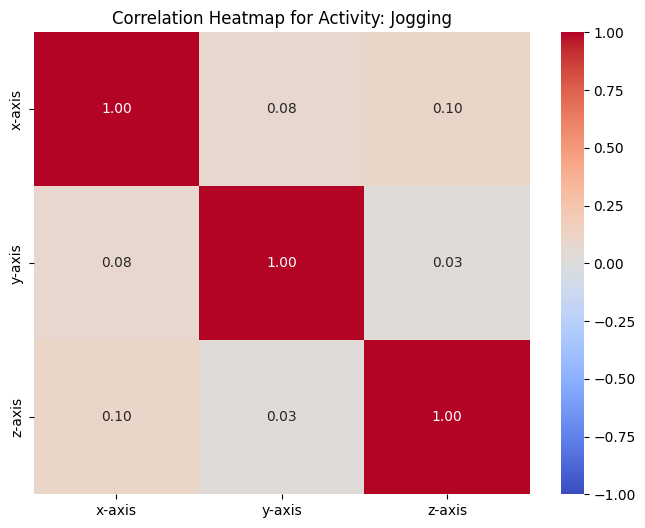

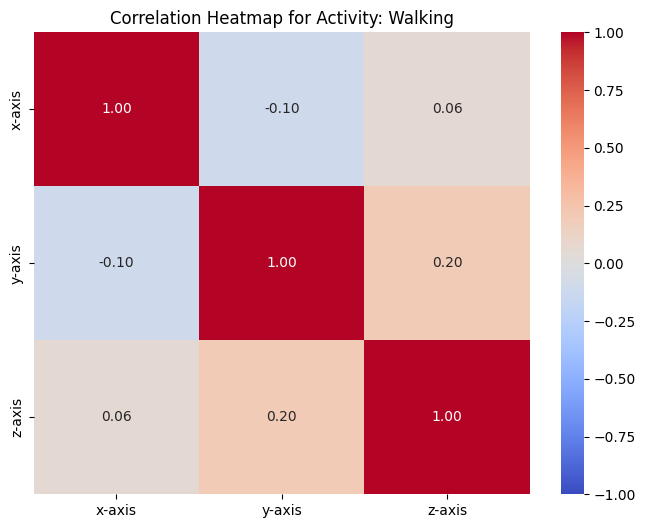

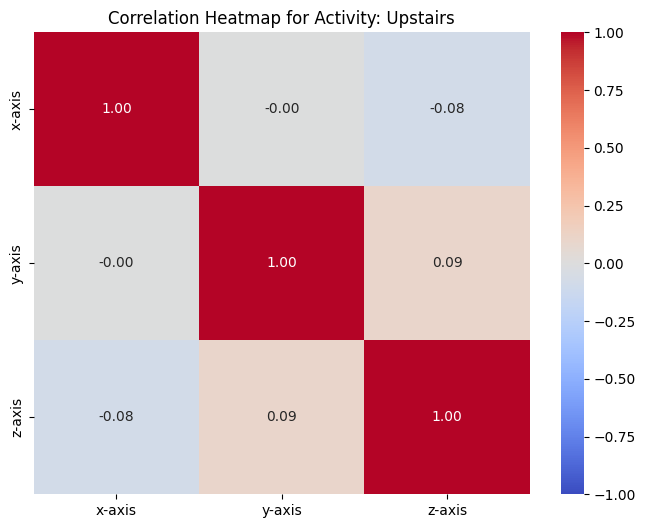

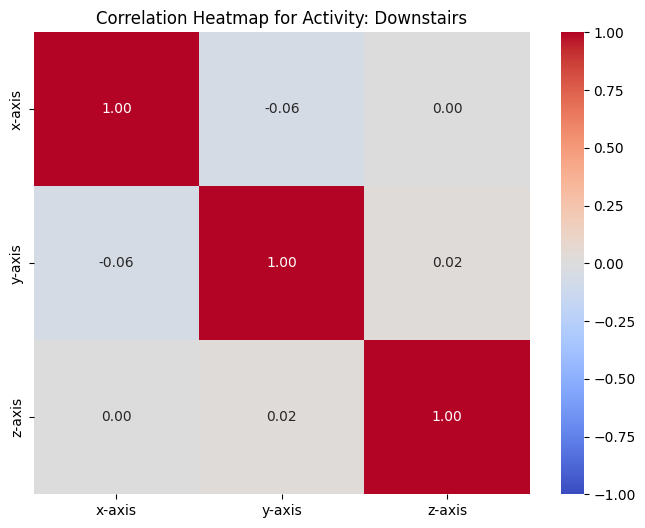

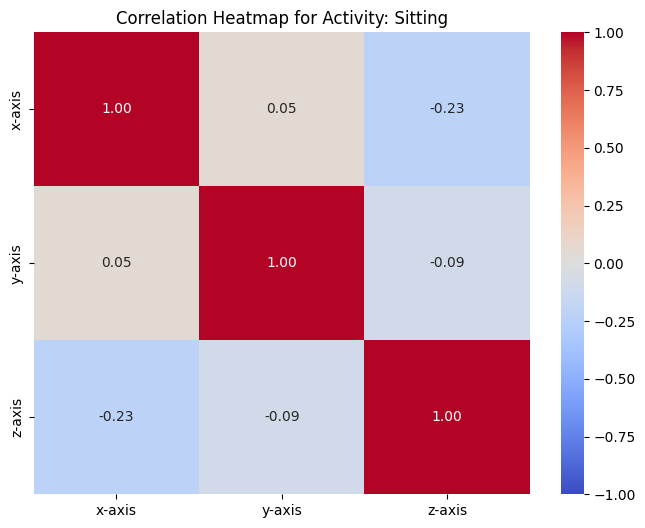

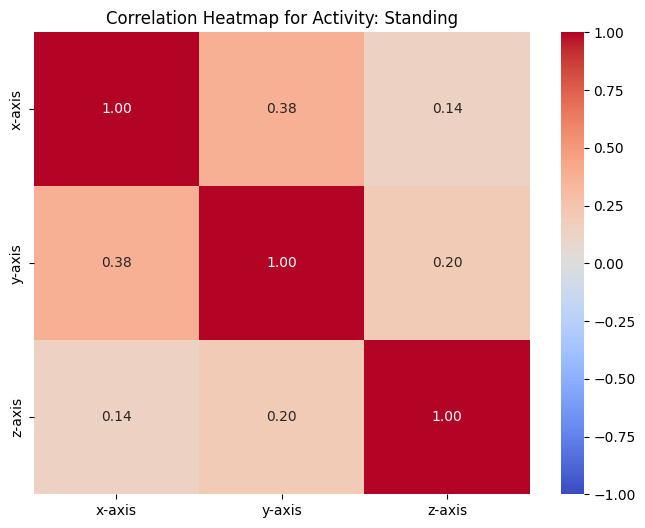

In [ ]:
# 활동별 상관관계 히트맵 생성
activities = df['activity'].unique()

for activity in activities:
    df_activity = df[df['activity'] == activity]

    sensor_data = df_activity[['x-axis', 'y-axis', 'z-axis']]

    # 데이터가 충분히 있어야 상관관계 계산이 가능
    if len(sensor_data) > 1:
        # 상관관계 행렬 계산
        correlation_matrix = sensor_data.corr()

        # 히트맵 시각화
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
        plt.title(f'Correlation Heatmap for Activity: {activity}')

#### Box Plot을 이용한 활동별 센서 값 비교
- 중앙값, 이상치 등을 파악

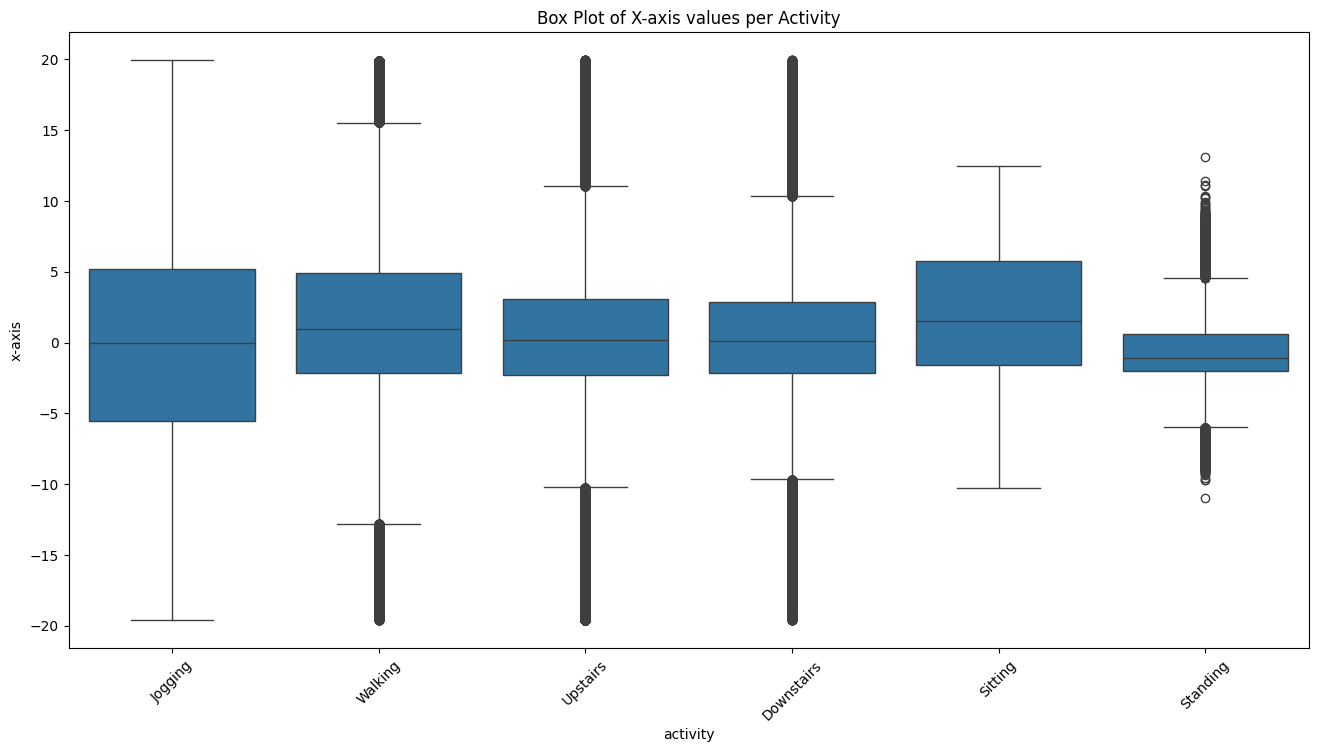

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='activity', y='x-axis', data=df)
plt.title('Box Plot of X-axis values per Activity')
plt.xticks(rotation=45)
plt.show()

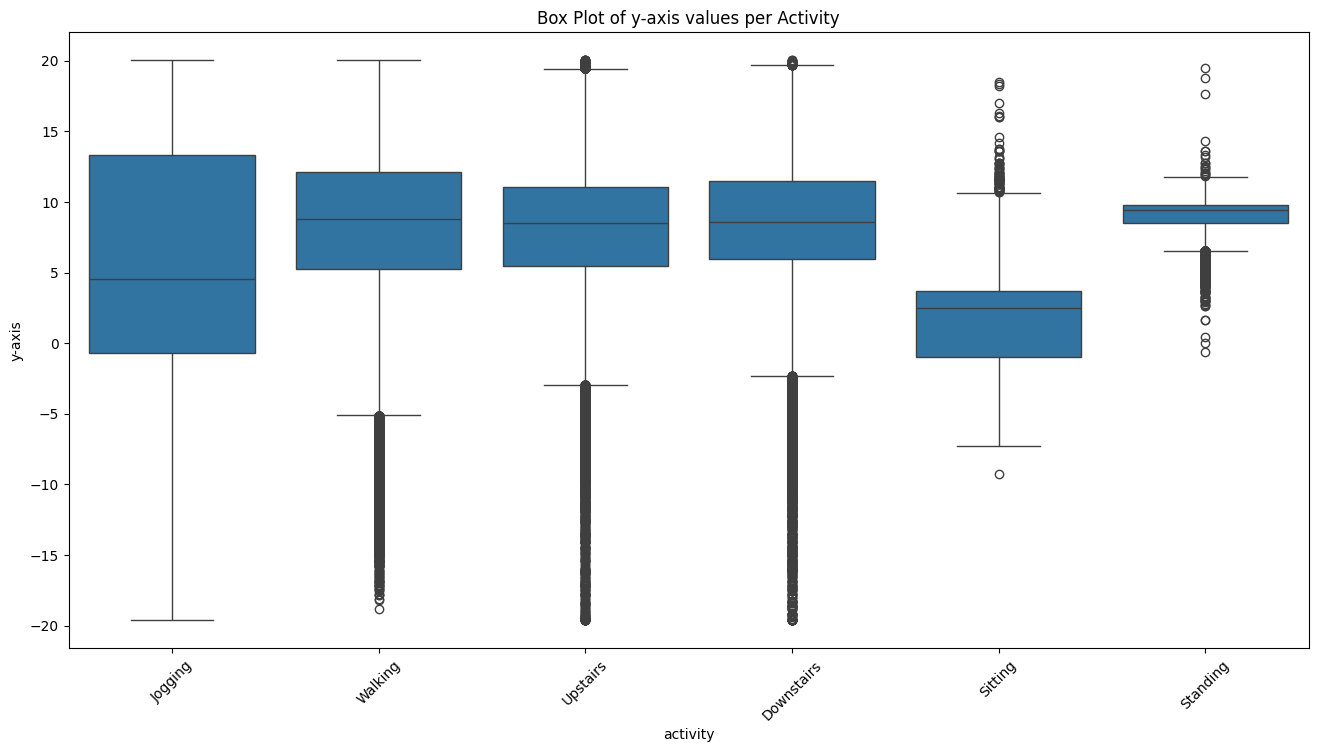

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='activity', y='y-axis', data=df)
plt.title('Box Plot of y-axis values per Activity')
plt.xticks(rotation=45)
plt.show()

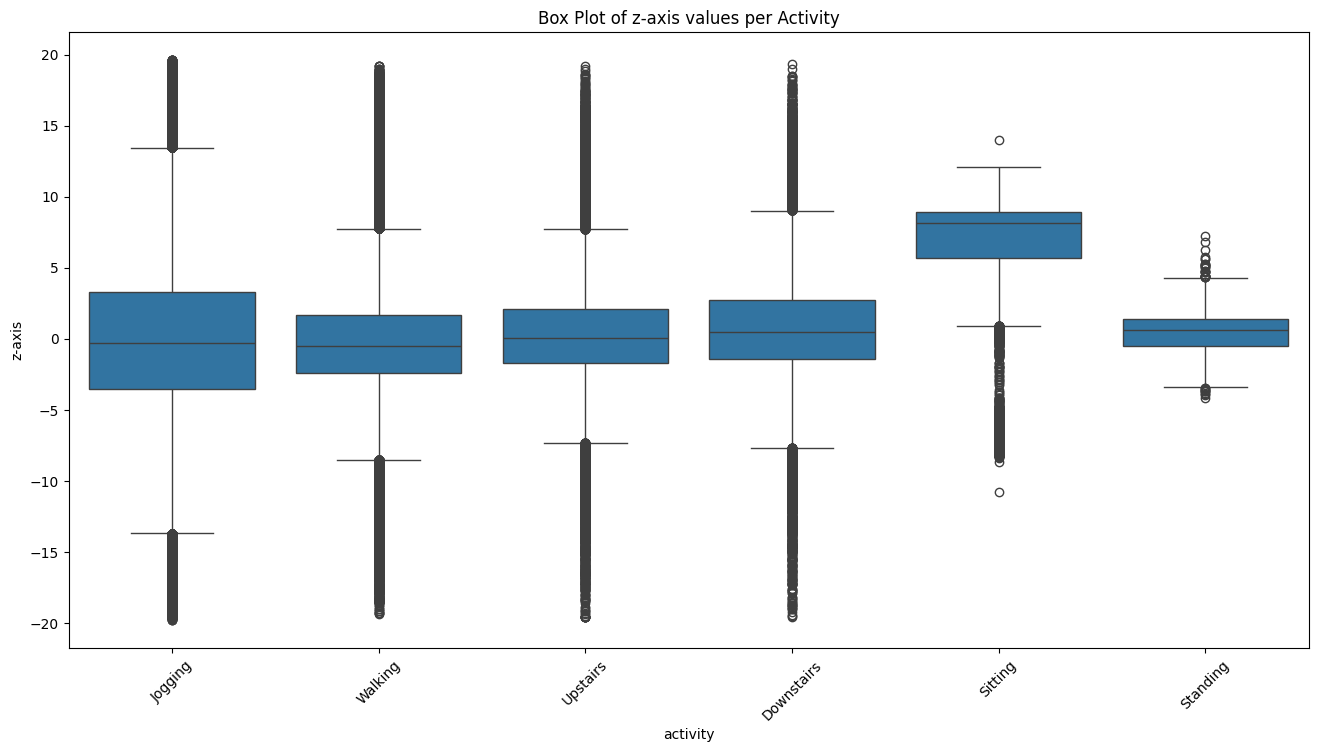

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='activity', y='z-axis', data=df)
plt.title('Box Plot of z-axis values per Activity')
plt.xticks(rotation=45)
plt.show()